In [10]:
backend = 'local' # if preferred, change this to one of the backends in your ~/.sjef/molpro/backends.xml that is ssh-accessible
parallel = 4 # how many jobs to run at once

In [11]:
from pysjef import all_completed, DirectoryNode
from pysjef_molpro import no_errors, Project
import numpy

In [12]:
root = DirectoryNode('potential_energy_curve')

In [26]:
grid = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2, 2.5, 3, 4, 5]
for i, D in enumerate(grid):
    p = root.add_child(f'd{i}', suffix='molpro')
    p.write_input(
    f"""angstrom;geometry={{
        H1
        H2 H1 {D} }}
    basis = cc-pVTZ
    rhf
    mrci""")

In [27]:
from multiprocessing.dummy import Pool
from operator import methodcaller
with Pool(processes=parallel) as pool:
    pool.map(methodcaller('run', backend=backend, wait=True),
             root.children, 1)
print('all completed', all_completed(root.children))
print('without errors', no_errors(root.children))

all completed True
without errors True


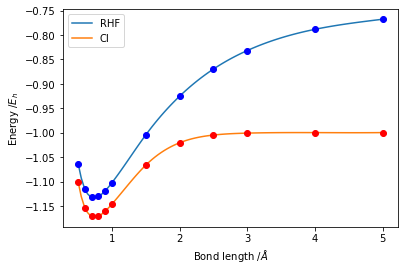

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as interp
ehf = root.select(
    '//jobstep[command=RHF-SCF]/property[name=Energy].value')
eci = root.select(
    '//jobstep[command=MRCI]/property[name=Energy].value')
interp_r=(np.linspace(grid[0],grid[-1],100))
plt.plot( interp_r, interp(grid,ehf)(interp_r),interp_r,interp(grid,eci)(interp_r))
plt.plot(grid, ehf, 'bo',grid,eci, 'ro')
plt.legend([r'RHF',r'CI'])
plt.xlabel(r'Bond length $/ \AA$')
plt.ylabel(r'Energy $/E_h$')
plt.savefig("potential_energy_curve.pdf", bbox_inches='tight')